# Predicting PAs (ongoing season)

This notebook develops the formalism to predict the number of plate appearances for a given player.

As the season progresses, we observe the number of games (`G`) the player has participated in out of the possible games to date (`T`). The likelihood function models the probability of observing this data given a hypothesized total number (`N`) of games for the player:

\[ P(G \mid N, T) = \text{Binomial}(G \mid N, T) \]

This is based on the assumption that each game is an independent event with its own probability.


## The ingredients

The ingredients in predicting PAs are the number of PA per game given the batting order location and the number of games. The latter is straightforward to predict in a first-order sense.

In [38]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# FantasyToolz stat-scraping library
import mlbstatscraping as mss

# probability helpers
from scipy.stats import beta, binom
from scipy.odr import ODR, Model, RealData



Let's start with a completely agnostic prior: if we assumed that a player had a 50/50 chance of playing any game at the start of the season, we'd imagine some sort of distribution centred around 81 games played. The distribution of choice is the Beta distribution, which deals with binary probabilities (i.e. yes/no answers).

See:

Text(0, 0.5, 'Probability Density')

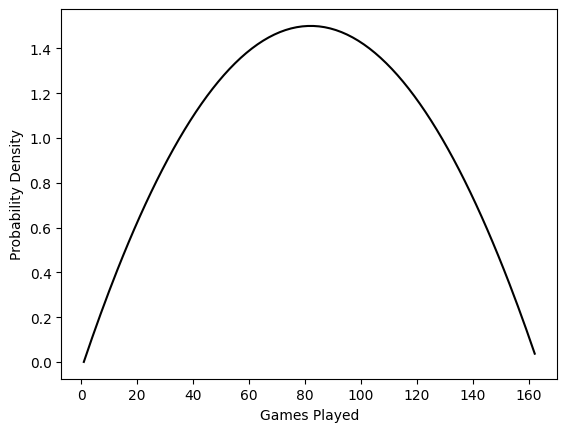

In [16]:

# Parameters for the prior Beta distribution
alpha_prior = 2 # number of games played in
beta_prior = 2 # number of games not played

# Initial prior distribution
prior = beta(alpha_prior, beta_prior)

total_games = 162
ngames = np.arange(1,total_games+1,1)
plt.plot(ngames,prior.pdf([x/total_games for x in range(total_games)]),color='black')
plt.xlabel('Games Played')
plt.ylabel('Probability Density')

As we gain more data, we can refine this further. Let's read in the data from the 2025 season to-date and look at an example player.

In [119]:
year = '2025'
datafile = '../data/Aggregate/Summaries/{}mean-player-batting-order.csv'.format(year)
BO2025 = pd.read_csv(datafile)
BO2025.head()

,player,avg,ngames,teamgames,team
0,Taylor Ward,1.00,21,21,LAA
1,Nolan Schanuel,5.05,21,21,LAA
2,Mike Trout,2.95,21,21,LAA
3,Jorge Soler,3.95,21,21,LAA
4,Tim Anderson,8.54,13,21,LAA


In this data file, we have the number of games a player has appeared in, and the number of games the team has played. Let's take Tim Anderson as an example case for our games played prediction.

alpha_prior [13]
beta_prior [8]


Text(0.5, 1.0, 'Prior Distribution for Tim Anderson')

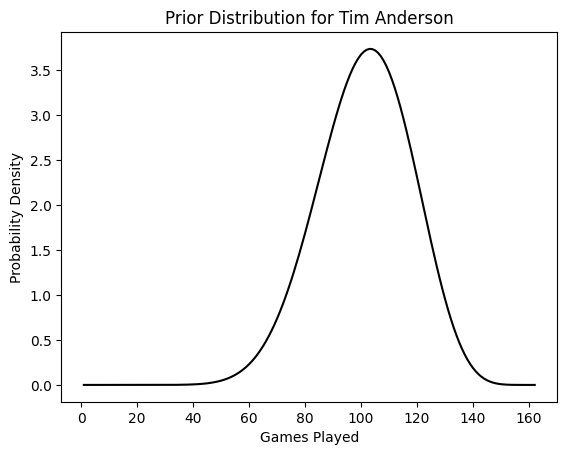

In [120]:

player = 'Tim Anderson'
alpha_prior = BO2025.loc[BO2025['player']==player]['ngames'].values # number of games played in
beta_prior = BO2025.loc[BO2025['player']==player]['teamgames'].values - alpha_prior # number of games not played
print('alpha_prior', alpha_prior)
print('beta_prior', beta_prior)

# Initial prior distribution
prior = beta(alpha_prior, beta_prior)

total_games = 162
ngames = np.arange(1,total_games+1,1)
plt.plot(ngames,prior.pdf([x/total_games for x in range(total_games)]),color='black')
plt.xlabel('Games Played')
plt.ylabel('Probability Density')
plt.title('Prior Distribution for {}'.format(player))

Let's reestablish the relationship between PA/G and batting order location, using 2024 data.



In [121]:
year = '2024'
datafile = '../data/Aggregate/Summaries/{}mean-player-batting-order.csv'.format(year)
BO2024 = pd.read_csv(datafile)
BO2024.head()

,player,avg,ngames,teamgames,team
0,Anthony Rendon,2.70,57,162,LAA
1,Aaron Hicks,4.00,14,162,LAA
2,Mike Trout,2.31,29,162,LAA
3,Taylor Ward,2.67,156,162,LAA
4,Brandon Drury,5.68,88,162,LAA


In [42]:
HittingDF2024 = mss.get_fangraphs_data('hitting',['2024'])
HittingDF2025 = mss.get_fangraphs_data('hitting',['2025'])

The year is 2024
The year is 2025


In [122]:
HittingDF2024.head()

,#,Name,Team,G,AB,PA,H,1B,2B,3B,...,IBB,SO,HBP,SF,SH,GDP,SB,CS,AVG,Year
13,12,Bobby Witt Jr.,KCR,161,636,709,211,123,45,11,...,9,106,8,8,0,4,31,12,.332,2024
15,14,Vladimir Guerrero Jr.,TOR,159,616,697,199,124,44,1,...,12,96,5,4,0,16,2,2,.323,2024
16,15,Aaron Judge,NYY,158,559,704,180,85,36,1,...,20,171,9,2,0,22,10,0,.322,2024
19,18,Luis Arraez,- - -,150,637,672,200,161,32,3,...,3,29,8,1,2,18,9,3,.314,2024
23,22,Shohei Ohtani,LAD,159,636,731,197,98,38,7,...,10,162,6,5,0,7,59,4,.310,2024


In [123]:
# pick a min PA for analysis
HittingDF2024 = HittingDF2024[HittingDF2024['PA'].values.astype('float')>400]
DataDF2024 = pd.merge(HittingDF2024, BO2024, how='left', left_on=['Name'], right_on=['player'])

# drop any nan values
DataDF2024 = DataDF2024.dropna(subset=['PA','G','avg'])

Text(0, 0.5, 'Plate Appearances per Game')

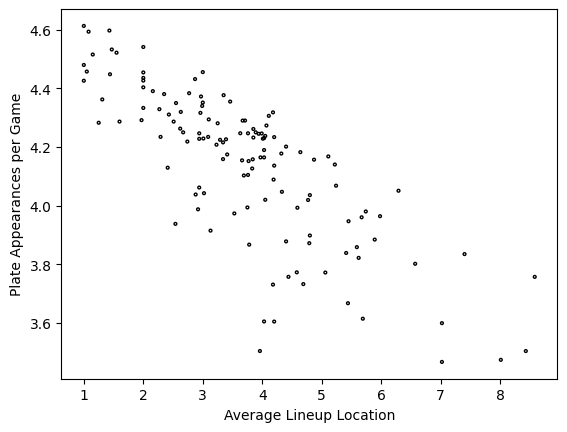

In [124]:
x_obs = DataDF2024['avg'].values
y_obs = (DataDF2024['PA'].astype('float')/DataDF2024['G'].astype('float')).values

plt.scatter(x_obs,y_obs,edgecolor='black',facecolor='none',s=4)
plt.xlabel('Average Lineup Location')
plt.ylabel('Plate Appearances per Game')

In [125]:
from scipy.stats import linregress
slope, intercept, *_ = linregress(x_obs, y_obs)
beta0 = [slope, intercept]
print(beta0)

[-0.13087104460305482, 4.62615606029841]


In [126]:
# Define the model function (linear)
def linear_model(B, x):
    return B[0] * x + B[1]

# Create a Model object
model = Model(linear_model)

# Create a RealData object with errors in both x and y
data = RealData(x_obs, y_obs, sx=0.1, sy=0.1)

# Set up ODR
odr = ODR(data, model, beta0=[-0.3, 4.5])
output = odr.run()

# Output the results
print("Fitted parameters:")
print(f"Slope: {output.beta[0]:.4f}")
print(f"Intercept: {output.beta[1]:.4f}")

Fitted parameters:
Slope: -0.1323
Intercept: 4.6313


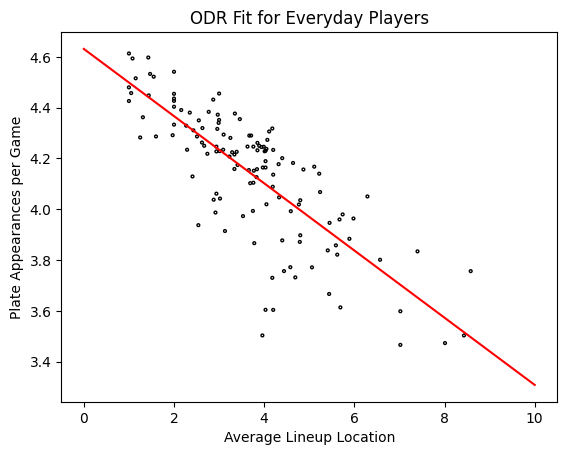

In [127]:
plt.scatter(x_obs,y_obs,edgecolor='black',facecolor='none',s=4)
plt.xlabel('Average Lineup Location')
plt.ylabel('Plate Appearances per Game')
plt.title('ODR Fit for Everyday Players')

x_fit = np.linspace(0, 10, 100)
y_fit = linear_model(output.beta, x_fit)
plt.plot(x_fit, y_fit, 'r-', label='ODR fit')


Our relationship for PAs from the 2024 season is then

$$ \frac{PA}{G}(BO) = -0.1323BO + 4.6313 $$

Text(0.5, 1.0, '2025 ODR Fit')

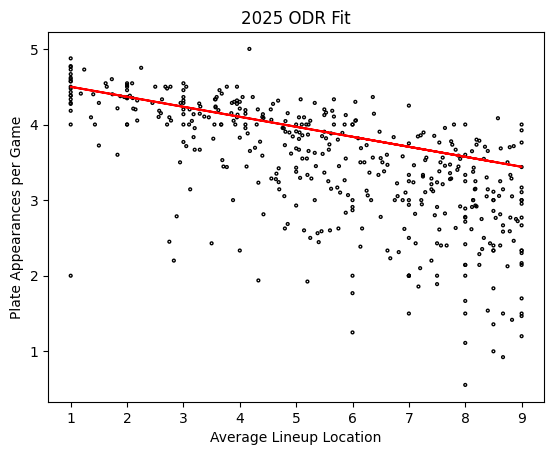

In [128]:
# let's apply to 2025 data and see how we are doing
# pick a min PA for analysis
HittingDF2025 = HittingDF2025[HittingDF2025['PA'].values.astype('float')>0]
DataDF2025 = pd.merge(HittingDF2025, BO2025, how='left', left_on=['Name'], right_on=['player'])

# drop any nan values
DataDF2025 = DataDF2025.dropna(subset=['PA','G','avg'])

x_obs = DataDF2025['avg'].values
y_obs = (DataDF2025['PA'].astype('float')/DataDF2025['G'].astype('float')).values


y_fit = linear_model(output.beta, x_obs)
plt.scatter(x_obs,y_obs,edgecolor='black',facecolor='none',s=4)
plt.plot(x_obs,y_fit,color='red')
plt.xlabel('Average Lineup Location')
plt.ylabel('Plate Appearances per Game')
plt.title('2025 ODR Fit')

alpha_prior [19]
beta_prior [4]


Text(0.5, 1.0, 'Full season 2025 PA Distribution for Wilyer Abreu')

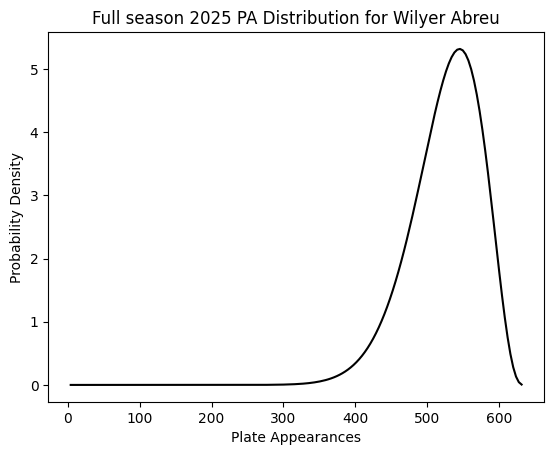

In [130]:

player = 'Wilyer Abreu'

alpha_prior = BO2025.loc[BO2025['player']==player]['ngames'].values # number of games played in
beta_prior = BO2025.loc[BO2025['player']==player]['teamgames'].values - alpha_prior # number of games not played
print('alpha_prior', alpha_prior)
print('beta_prior', beta_prior)

# Initial prior distribution
prior = beta(alpha_prior, beta_prior)

total_games = 162
ngames = np.arange(1,total_games+1,1)

x_obs = DataDF2025.loc[DataDF2025['player']==player]['avg'].values

y_fit = linear_model(output.beta, x_obs)


plt.plot(y_fit*ngames,prior.pdf([x/total_games for x in range(total_games)]),color='black')

# now take the peak and the 95% confidence interval

plt.xlabel('Plate Appearances')
plt.ylabel('Probability Density')
plt.title('Full season 2025 PA Distribution for {}'.format(player))

In [132]:

DataDF2025['PAprediction'] = np.zeros(len(DataDF2025))
DataDF2025['PAprediction_uncertainty'] = np.zeros(len(DataDF2025))

for player in DataDF2025['player'].unique():
    alpha_prior = BO2025.loc[BO2025['player']==player]['ngames'].values # number of games played in
    beta_prior = BO2025.loc[BO2025['player']==player]['teamgames'].values - alpha_prior # number of games not played
    #print('alpha_prior', alpha_prior[0])
    #print('beta_prior', beta_prior[0])
    alpha_prior += 2
    beta_prior += 2

    if alpha_prior[0] <= 0:
        print('Broken Prior for {} ({})'.format(player, alpha_prior[0]))
        continue
    if beta_prior[0] <= 0:
        print('Broken Prior for {} ({})'.format(player, beta_prior[0]))
        continue
    # Initial prior distribution
    prior = beta(alpha_prior[0], beta_prior[0])

    total_games = 162
    ngames = np.arange(1,total_games+1,1)
    x_obs = DataDF2025.loc[DataDF2025['player']==player]['avg'].values
    y_fit = linear_model(output.beta, x_obs)
    cdfvals = prior.cdf([x/total_games for x in range(total_games)])
    pavals = y_fit*ngames
    p50 = pavals[np.nanargmin(np.abs(cdfvals-0.5))]
    p14 = pavals[np.nanargmin(np.abs(cdfvals-0.14))]
    p86 = pavals[np.nanargmin(np.abs(cdfvals-0.86))]

    DataDF2025.loc[DataDF2025['player']==player,'PAprediction'] = p50
    DataDF2025.loc[DataDF2025['player']==player,'PAprediction_uncertainty'] = p86 - p14

Broken Prior for Max Muncy (-15)


Text(0.5, 1.0, '2025 PA Prediction for Everyday Players')

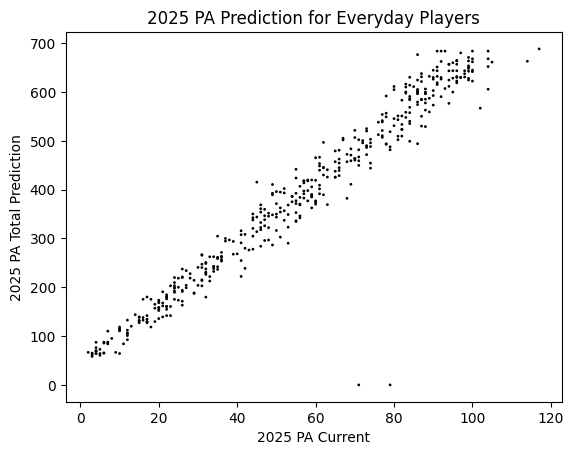

In [133]:
plt.scatter(DataDF2025['PA'].values.astype('float'),DataDF2025['PAprediction'],facecolor='black',edgecolor='none',s=4)
plt.xlabel('2025 PA Current')
plt.ylabel('2025 PA Total Prediction')
plt.title('2025 PA Prediction for Everyday Players')

Text(0.5, 1.0, '2025 PA Prediction for Everyday Players')

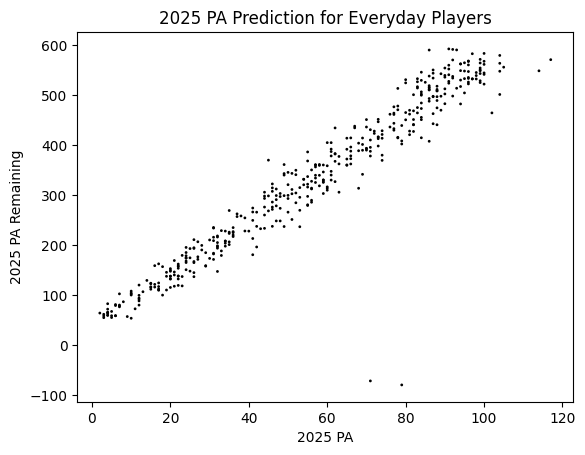

In [134]:
plt.scatter(DataDF2025['PA'].values.astype('float'),DataDF2025['PAprediction']-DataDF2025['PA'].values.astype('float'),facecolor='black',edgecolor='none',s=4)
plt.xlabel('2025 PA')
plt.ylabel('2025 PA Remaining')
plt.title('2025 PA Prediction for Everyday Players')

347.1977505565201 70.14095970838792 63.12686373754906


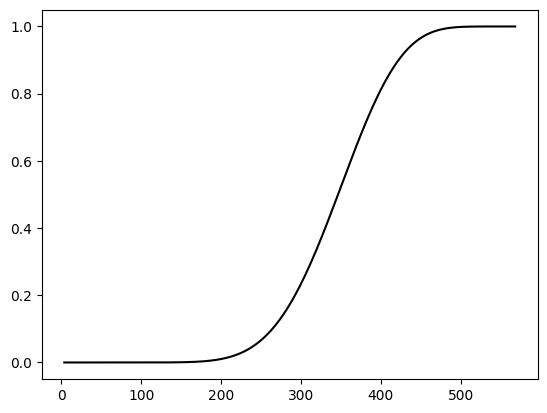

In [ ]:
plt.plot(y_fit*ngames,prior.cdf([x/total_games for x in range(total_games)]),color='black')
cdfvals = prior.cdf([x/total_games for x in range(total_games)])
pavals = y_fit*ngames
p50 = pavals[np.nanargmin(np.abs(cdfvals-0.5))]
p14 = pavals[np.nanargmin(np.abs(cdfvals-0.14))]
p86 = pavals[np.nanargmin(np.abs(cdfvals-0.86))]
print(p50,p50-p14,p86-p50)
# do downside predictions


In [31]:
A = pd.read_csv('data/Aggregate/mean-player-batting-order-2024.csv')
A

,player,avg,ngames,teamgames,team
0,Anthony Rendon,1.25,32,104,LAA
1,Aaron Hicks,4.15,13,104,LAA
2,Mike Trout,2.29,28,104,LAA
3,Taylor Ward,3.12,100,104,LAA
4,Brandon Drury,5.23,48,104,LAA
...,...,...,...,...,...
572,Jose Trevino,8.22,46,105,NYY
573,Jahmai Jones,7.10,10,105,NYY
574,DJ LeMahieu,7.72,39,105,NYY
575,Ben Rice,3.85,26,105,NYY


In [45]:
plr = 'Mike Trout'
f = open('data/Aggregate/most_likely_ngames.txt','a')
print('plr,ngames',file=f)

for plr in A['player']:
    alpha_update = A.loc[A['player']==plr]['ngames'].values[0]
    beta_update = A.loc[A['player']==plr]['teamgames'].values[0] - alpha_update

    prior = beta(alpha_update, beta_update)
    
    #plt.clf()
    #plt.gcf()
    #plt.plot(ngames,prior.pdf([x/162 for x in range(162)])/np.sum(prior.pdf([x/162 for x in range(162)])),color='black')
    #plt.xlabel('Total games played prediction')
    #plt.ylabel('Probability density')
    #plt.title('{0}: most likely ngames={1}'.format(plr,np.argmax(prior.pdf([x/162 for x in range(162)]))))
    print('{0},{1}'.format(plr,np.argmax(prior.pdf([x/162 for x in range(162)]))),file=f)
    #plt.tight_layout()
    #plt.savefig('/Users/mpetersen/Desktop/tmpimages/{0}_ngames.png'.format(plr))

f.close()

58
Sum of probabilities: 1.0
Predicted games distribution: [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000

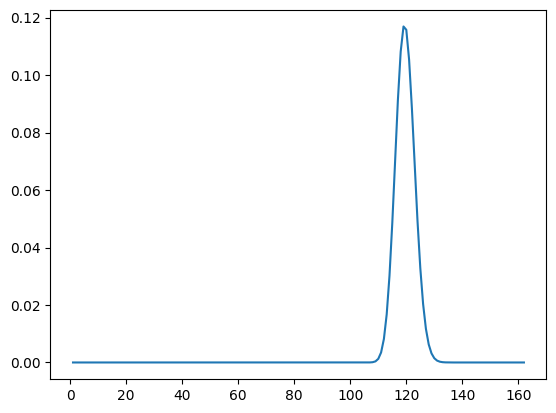

In [39]:
probability_playing = prior.mean()

# Number of games played so far
games_played_so_far = A.loc[A['player']==plr]['teamgames'].values[0]

# Remaining games
remaining_games = total_games - games_played_so_far
print(remaining_games)

# Calculate the probability of playing exactly k games out of the remaining games
probabilities = np.array([binom.pmf(k, remaining_games, probability_playing) for k in range(remaining_games + 1)])

# Normalization (in this case, it should already sum to 1, but we ensure it)
probabilities /= probabilities.sum()

# Total predicted games played distribution
predicted_games_distribution = np.zeros(total_games + 1)
predicted_games_distribution[games_played_so_far:games_played_so_far + remaining_games + 1] = probabilities

# Check the normalization
print(f'Sum of probabilities: {predicted_games_distribution.sum()}')
print(f'Predicted games distribution: {predicted_games_distribution}')

plt.plot(ngames,predicted_games_distribution[1:])


In [37]:
predicted_games_distribution.size

163

In [49]:
B = pd.read_csv('data/Aggregate/most_likely_ngames.txt')
sorted_df = B.sort_values(by='ngames',ascending=False)
print("\nSorted DataFrame by column 'B':")
print(sorted_df)




Sorted DataFrame by column 'B':
                  plr  ngames
352  Nick Castellanos     161
418      Jarren Duran     161
83         Matt Olson     161
84      Marcell Ozuna     161
483    Bobby Witt Jr.     161
..                ...     ...
342    Matthew Batten       0
399          Sam Huff       0
434    Tyler Heineman       0
457        Livan Soto       0
576    Carlos Narvaez       0

[577 rows x 2 columns]
                       plr  ngames
352       Nick Castellanos     161
418           Jarren Duran     161
83              Matt Olson     161
84           Marcell Ozuna     161
483         Bobby Witt Jr.     161
278       Francisco Lindor     160
567          Anthony Volpe     160
312       Gunnar Henderson     160
160       Christian Walker     159
279            Pete Alonso     159
62   Vladimir Guerrero Jr.     159
563            Aaron Judge     159
334       Jurickson Profar     159
443        Elly De La Cruz     159
180      Teoscar Hernandez     159
177        Freddie Free

In [50]:
print(sorted_df.head(50))

                       plr  ngames
352       Nick Castellanos     161
418           Jarren Duran     161
83              Matt Olson     161
84           Marcell Ozuna     161
483         Bobby Witt Jr.     161
278       Francisco Lindor     160
567          Anthony Volpe     160
312       Gunnar Henderson     160
160       Christian Walker     159
279            Pete Alonso     159
62   Vladimir Guerrero Jr.     159
563            Aaron Judge     159
334       Jurickson Profar     159
443        Elly De La Cruz     159
180      Teoscar Hernandez     159
177        Freddie Freeman     159
29             Jeremy Pena     159
383          Marcus Semien     159
258              Josh Bell     159
260       Bryan De La Cruz     159
439          Spencer Steer     157
333           Ha-Seong Kim     157
218           Jose Ramirez     157
365         Bryan Reynolds     157
176          Shohei Ohtani     157
3              Taylor Ward     157
22             Jose Altuve     157
25            Alex B